In [23]:
#As always, we import everything
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### 1. A naive analysis

In [24]:
data = pd.read_csv('lalonde.csv')
data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


In [41]:
data_non_treatment = data[data.treat == 0][['re78']].values
data_treatment = data[data.treat == 1][['re78']].values

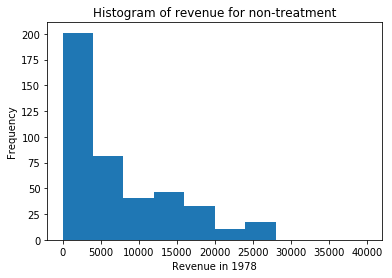

In [52]:
plt.hist(data_non_treatment, range=[0, 40000])
plt.title("Histogram of revenue for non-treatment")
plt.xlabel("Revenue in 1978")
plt.ylabel("Frequency")
plt.show()

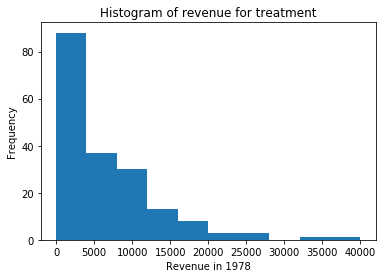

In [53]:
plt.hist(data_treatment, range=[0, 40000])
plt.title("Histogram of revenue for treatment")
plt.xlabel("Revenue in 1978")
plt.ylabel("Frequency")
plt.show()

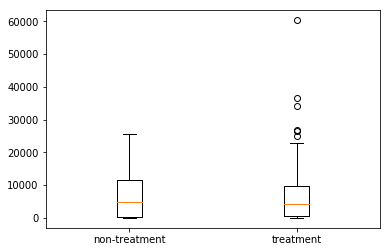

In [51]:
plt.boxplot([data_non_treatment, data_treatment])
plt.xticks([1, 2], ['non-treatment', 'treatment'])
plt.show()

As we can see from those basic histograms and the box plot, the 'treatment' population has a lower income (except for a few outliers).
A naïve researcher could conclude that the treatment is not only inneficient, but also diminishes the income of the participant.